# Atividade 3: xG

## Referências

- [Soccermatics](https://soccermatics.readthedocs.io/en/latest/gallery/lesson2/plot_xGModelFit.html)
- [kloppy](https://kloppy.pysport.org)
- [socceraction](https://socceraction.readthedocs.io/en/latest)
- [socceraction: Wyscout -> SPADL](https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.spadl.wyscout.convert_to_actions.html)
- [socceraction: Statsbomb -> SPADL](https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.spadl.statsbomb.convert_to_actions.html)

In [1]:
# prompt: importar zip de um link e descompactar na pasta raiz

import requests
import zipfile
import io
import os
import IPython

def download_and_extract_zip(url, extract_to='.'):
    """Downloads a zip file from a URL and extracts it to a specified directory.

    Args:
        url: The URL of the zip file.
        extract_to: The directory to extract the zip file to. Defaults to the current directory.
    """
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an exception for non-200 status codes

        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Successfully downloaded and extracted zip file from {url} to {extract_to}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading zip file: {e}")
    except zipfile.BadZipFile as e:
        print(f"Error extracting zip file: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

zip_file_url = "https://github.com/juliogdomingues/cdaf_ufmg/raw/refs/heads/main/At3/all_files_World_Cup.zip"
download_and_extract_zip(zip_file_url)

Successfully downloaded and extracted zip file from https://github.com/juliogdomingues/cdaf_ufmg/raw/refs/heads/main/At3/all_files_World_Cup.zip to .


In [ ]:
# padronizando as versões
# !pip install pandas==2.0.3
!pip install numpy==1.26.4 matplotlib socceraction mplsoccer multimethod==1.9.1 --quiet

# Recarregar runtime
print("Reiniciando runtime")
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 699.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 5.0 MB/s eta 0:00:00


In [1]:
import pandas as pd
import socceraction.spadl as spadl
import mplsoccer as mps
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import scipy
import numpy as np
import json
from tqdm import tqdm

/usr/local/lib/python3.11/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


## Questão 1

Baixe o dataset [Wyscout Europa Top 5 2017/2018](https://figshare.com/collections/Soccer_match_event_dataset/4415000).

* Vá até o final da página. Lá você vai encontrar múltiplos datasets. O principal é o de Eventos; mas use os demais para adicionar informações (como correspondência id<->jogador)

Escolha uma partida e carregue os dados de eventos em um dataframe do pandas.

In [2]:
# Load datasets
events = pd.read_json('events_World_Cup.json')
players = pd.read_json('players.json')
matches = pd.read_json('matches_World_Cup.json')
teams = pd.read_json('teams.json')

# eventid2name = pd.read_csv('eventid2name.csv')
# tags2name = pd.read_csv('tags2name.csv')

# with open('playerank.json', 'r') as f:
#     playerank_data = json.load(f)
# playerank = pd.DataFrame(playerank_data)

In [3]:
# pré processamento em colunas da tabela de eventos para facilitar a conversão p/ SPADL
events = events.rename(columns={'id': 'event_id', 'eventId': 'type_id', 'subEventId': 'subtype_id',
                                'teamId': 'team_id', 'playerId': 'player_id', 'matchId': 'game_id'})
events['milliseconds'] = events['eventSec'] * 1000
events['period_id'] = events['matchPeriod'].replace({'1H': 1, '2H': 2})

In [4]:
team_matches = []
for i in tqdm(range(len(matches))):
    match = pd.DataFrame(matches.loc[i, 'teamsData']).T
    match['matchId'] = matches.loc[i, 'wyId']
    team_matches.append(match)
team_matches = pd.concat(team_matches).reset_index(drop=True)

100%|██████████| 64/64 [00:00<00:00, 181.89it/s]


In [5]:
from tqdm.notebook import tqdm

# fazendo a conversão p/ SPADL, padronizando a direção de jogo da esquerda p/ a direita e adicionando os nomes dos tipos de ações
all_actions = []
game_ids = events.game_id.unique().tolist()

with tqdm(total=len(game_ids), desc="Convertendo jogos para SPADL", position=0, disable=False) as pbar:
    for g in game_ids:
        match_events = events.loc[events.game_id == g]
        match_home_id = team_matches.loc[(team_matches.matchId == g) & (team_matches.side == 'home'), 'teamId'].values[0]
        match_actions = spadl.wyscout.convert_to_actions(events=match_events, home_team_id=match_home_id)
        match_actions = spadl.play_left_to_right(actions=match_actions, home_team_id=match_home_id)
        match_actions = spadl.add_names(match_actions)
        all_actions.append(match_actions)
        pbar.update(1)
        pbar.refresh()

all_actions = pd.concat(all_actions).reset_index(drop=True)

Convertendo jogos para SPADL:   0%|          | 0/64 [00:00<?, ?it/s]

In [6]:
all_actions.head()

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name
0,2057954,1,1.656214,16521,122671,52.50,34.00,36.75,31.96,258612104,0,0,1,0,pass,success,foot
1,2057954,1,4.487814,16521,139393,36.75,31.96,78.75,55.08,258612106,0,0,1,1,pass,success,foot
2,2057954,1,6.524990,16521,122847,78.75,55.08,66.15,56.44,NaN,0,21,1,2,dribble,success,foot
3,2057954,1,8.562167,16521,122847,66.15,56.44,74.55,57.80,258612110,0,0,1,3,pass,success,foot
4,2057954,1,10.991292,16521,122832,74.55,57.80,96.60,60.52,258612113,0,0,1,4,pass,success,foot


In [7]:
# adicionando o nome dos jogadores
players = pd.read_json("players.json")
players['player_name'] = players['firstName'] + ' ' + players['lastName']
players['preferred_foot'] = players['foot']
players = players[['wyId', 'player_name', 'preferred_foot']].rename(columns={'wyId': 'player_id'})
all_actions = pd.merge(all_actions, players, on='player_id', how='left')

In [8]:
all_actions.head()

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name,preferred_foot
0,2057954,1,1.656214,16521,122671,52.50,34.00,36.75,31.96,258612104,0,0,1,0,pass,success,foot,Mohammad Ibrahim Al Sahlawi,right
1,2057954,1,4.487814,16521,139393,36.75,31.96,78.75,55.08,258612106,0,0,1,1,pass,success,foot,Abdullah Ibrahim Otayf,right
2,2057954,1,6.524990,16521,122847,78.75,55.08,66.15,56.44,NaN,0,21,1,2,dribble,success,foot,Salman Mohammed Al Faraj,left
3,2057954,1,8.562167,16521,122847,66.15,56.44,74.55,57.80,258612110,0,0,1,3,pass,success,foot,Salman Mohammed Al Faraj,left
4,2057954,1,10.991292,16521,122832,74.55,57.80,96.60,60.52,258612113,0,0,1,4,pass,success,foot,Salem Mohammed Al Dawsari,right


In [9]:
# Extrair informações dos times para cada jogo
match_info = []
for i in range(len(matches)):
    match_id = matches.loc[i, 'wyId']
    home_team_id = team_matches.loc[(team_matches['matchId'] == match_id) & (team_matches['side'] == 'home'), 'teamId'].values[0]
    away_team_id = team_matches.loc[(team_matches['matchId'] == match_id) & (team_matches['side'] == 'away'), 'teamId'].values[0]

    home_team_name = teams.loc[teams['wyId'] == home_team_id, 'name'].values[0]
    away_team_name = teams.loc[teams['wyId'] == away_team_id, 'name'].values[0]

    match_info.append({
        'game_id': match_id,
        'home_team': home_team_name,
        'away_team': away_team_name,
        'label': f"{home_team_name} vs {away_team_name}"
    })

match_info_df = pd.DataFrame(match_info)

# Exibir os jogos disponíveis
print("Jogos disponíveis:")
for idx, row in match_info_df.iterrows():
    print(f"ID: {row['game_id']} - {row['label']}")

# dropdown interativo
from IPython.display import display
import ipywidgets as widgets

dropdown = widgets.Dropdown(
    options=[(row['label'], row['game_id']) for idx, row in match_info_df.iterrows()],
    description='Selecione o jogo:',
    disabled=False,
)

display(dropdown)

# Função para atualizar as ações selecionadas com base no dropdown
def update_selected_actions(change):
    global selected_game_id, selected_game_actions  # Declare as global to modify them
    selected_game_id = change.new
    selected_game_actions = all_actions[all_actions['game_id'] == selected_game_id]
    print(f"Número de ações no jogo selecionado ({selected_game_id}): {len(selected_game_actions)}")

dropdown.observe(update_selected_actions, names='value')

# Inicializar selected_game_id e selected_game_actions com o primeiro jogo
selected_game_id = dropdown.value
selected_game_actions = all_actions[all_actions['game_id'] == selected_game_id]
print(f"Número de ações no jogo selecionado ({selected_game_id}): {len(selected_game_actions)}")

Jogos disponíveis:
ID: 2058017 - France vs Croatia
ID: 2058016 - Belgium vs England
ID: 2058015 - Croatia vs England
ID: 2058014 - France vs Belgium
ID: 2058012 - Russia vs Croatia
ID: 2058013 - Sweden vs England
ID: 2058011 - Brazil vs Belgium
ID: 2058010 - Uruguay vs France
ID: 2058009 - Colombia vs England
ID: 2058008 - Sweden vs Switzerland
ID: 2058007 - Belgium vs Japan
ID: 2058006 - Brazil vs Mexico
ID: 2058005 - Croatia vs Denmark
ID: 2058004 - Spain vs Russia
ID: 2058002 - Uruguay vs Portugal
ID: 2058003 - France vs Argentina
ID: 2057994 - England vs Belgium
ID: 2057995 - Panama vs Tunisia
ID: 2058000 - Japan vs Poland
ID: 2058001 - Senegal vs Colombia
ID: 2057982 - Serbia vs Brazil
ID: 2057983 - Switzerland vs Costa Rica
ID: 2057989 - Mexico vs Sweden
ID: 2057988 - Korea Republic vs Germany
ID: 2057976 - Nigeria vs Argentina
ID: 2057977 - Iceland vs Croatia
ID: 2057971 - Australia vs Peru
ID: 2057970 - Denmark vs France
ID: 2057965 - Spain vs Morocco
ID: 2057964 - Iran vs Port

Dropdown(description='Selecione o jogo:', options=(('France vs Croatia', 2058017), ('Belgium vs England', 2058…

Número de ações no jogo selecionado (2058017): 1128


### 1.1

Crie um dataframe "shots", contendo apenas os chutes.

Adicione colunas no dataframe "shots" a serem usadas como as features de um modelo de xG.

Justifique a escolha das features.

In [10]:
shots = all_actions[all_actions['type_name'] == 'shot'].copy()

shots.head()

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name,preferred_foot
83,2057954,1,327.142941,16521,122940,91.35,49.64,91.35,49.64,258612248,5,11,0,83,shot,fail,foot_right,Yasir Gharsan Al Shahrani,right
112,2057954,1,407.123899,14358,101699,94.50,21.08,94.50,21.08,258612244,5,11,0,112,shot,fail,foot_right,Alexandr Samedov,right
142,2057954,1,526.276996,14358,101857,90.30,47.60,90.30,47.60,258612307,4,11,0,142,shot,fail,foot_left,Yuri Zhirkov,left
171,2057954,1,693.396917,14358,102157,97.65,27.20,105.00,37.40,258612368,3,11,1,171,shot,success,head/other,Yury Gazinskiy,right
283,2057954,1,1266.276267,16521,122671,90.30,42.16,90.30,42.16,258612558,4,11,0,283,shot,fail,foot_left,Mohammad Ibrahim Al Sahlawi,right


In [11]:
# Centro do Gol em SPADL - Pelo que entendi (105x68)
X_GOL = 105
Y_GOL = 34

# 1. Distância do gol
shots['distance_to_goal'] = np.sqrt((shots['start_x'] - X_GOL) ** 2 + (shots['start_y'] - Y_GOL) ** 2)

# 2. Ângulo do gol - usando as traves
goal_width_y = 7.32 * 68 / 105 # assumindo largura do gol ~7.32m, que é ~4.68 na escala Y 0-68)
y_post_1 = Y_GOL - goal_width_y / 2
y_post_2 = Y_GOL + goal_width_y / 2

a = np.sqrt((shots['start_x'] - X_GOL)**2 + (shots['start_y'] - y_post_1)**2)
b = np.sqrt((shots['start_x'] - X_GOL)**2 + (shots['start_y'] - y_post_2)**2)
c = goal_width_y
shots['angle_to_goal'] = np.arccos((a**2 + b**2 - c**2) / (2 * a * b)) * (180 / np.pi) # Ângulo em graus
# Correção para NaN se a ou b forem zero (tiro na linha do gol, ângulo=180)
shots['angle_to_goal'] = shots['angle_to_goal'].fillna(180.0)

# 3. Tipo de finalização
shots['shot_type'] = shots['bodypart_name']

# 4. Chute com perna forte?
shots['strong_foot_shot'] = np.where(
    (shots['preferred_foot'] == 'left') & (shots['bodypart_name'] == 'foot_left') |
    (shots['preferred_foot'] == 'right') & (shots['bodypart_name'] == 'foot_right'),
    1,  # Pé dominante
    0   # Pé não dominante ou qualquer outra parte do corpo
)

# Verificando as novas colunas
print(shots.head(10))
print(shots[['distance_to_goal', 'angle_to_goal', 'shot_type', 'strong_foot_shot']].describe())

     game_id period_id  time_seconds  team_id  player_id  start_x  start_y  \
83   2057954         1    327.142941    16521     122940    91.35    49.64   
112  2057954         1    407.123899    14358     101699    94.50    21.08   
142  2057954         1    526.276996    14358     101857    90.30    47.60   
171  2057954         1    693.396917    14358     102157    97.65    27.20   
283  2057954         1   1266.276267    16521     122671    90.30    42.16   
357  2057954         1   1647.458358    16521     122832    76.65    46.24   
371  2057954         1   1820.377754    16521     122940    92.40    29.92   
543  2057954         1   2532.304606    14358       4513    97.65    42.16   
710  2057954         2    370.863230    14358     101699    84.00    22.44   
764  2057954         2    631.700199    16521     122671    96.60    27.20   

      end_x  end_y original_event_id  ...  action_id  type_name  result_name  \
83    91.35  49.64         258612248  ...         83       sh

As features escolhidas para o modelo de xG – distância ao gol, ângulo do gol, tipo de finalização e se o chute foi com a perna boa – refletem fatores cruciais que influenciam a probabilidade de um chute resultar em gol. Chutes mais próximos e com ângulos maiores tendem a ter maior probabilidade de sucesso, enquanto o tipo de finalização e o uso da perna forte adicionam nuances à qualidade do chute.

## Questão 2

Agora, crie seu próprio modelo de *expected goals*. Use os slides como guia -- você tem liberdade de usar qualquer método (ex: [regressão logística](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).

Reporte a acurácia do modelo para os conjuntos de treino (.score(X_train, y_train)) e teste (.score(X_test, y_test)).

In [12]:
shots

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,...,action_id,type_name,result_name,bodypart_name,player_name,preferred_foot,distance_to_goal,angle_to_goal,shot_type,strong_foot_shot
83,2057954,1,327.142941,16521,122940,91.35,49.64,91.35,49.64,258612248,...,83,shot,fail,foot_right,Yasir Gharsan Al Shahrani,right,20.758904,8.650847,foot_right,1
112,2057954,1,407.123899,14358,101699,94.50,21.08,94.50,21.08,258612244,...,112,shot,fail,foot_right,Alexandr Samedov,right,16.648616,10.386886,foot_right,1
142,2057954,1,526.276996,14358,101857,90.30,47.60,90.30,47.60,258612307,...,142,shot,fail,foot_left,Yuri Zhirkov,left,20.026233,9.994535,foot_left,1
171,2057954,1,693.396917,14358,102157,97.65,27.20,105.00,37.40,258612368,...,171,shot,success,head/other,Yury Gazinskiy,right,10.013116,20.211142,head/other,0
283,2057954,1,1266.276267,16521,122671,90.30,42.16,90.30,42.16,258612558,...,283,shot,fail,foot_left,Mohammad Ibrahim Al Sahlawi,right,16.812959,14.118363,foot_left,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80605,2058017,2,1389.182669,9598,14943,96.60,31.96,105.00,37.40,263885208,...,814,shot,success,foot_right,Mario Mand\u017euki\u0107,right,8.644166,29.952695,foot_right,1
80680,2058017,2,1802.299261,9598,69409,68.25,26.52,105.00,40.80,263885299,...,889,shot,fail,foot_right,\u0160ime Vrsaljko,right,37.503505,7.088938,foot_right,1
80710,2058017,2,1933.996341,9598,3476,85.05,45.56,85.05,45.56,263885348,...,919,shot,fail,foot_left,Ivan Rakiti\u0107,right,23.057235,10.192493,foot_left,0
80812,2058017,2,2487.443304,4418,28115,81.90,16.32,105.00,37.40,263885485,...,1021,shot,fail,foot_left,Nabil Fekir,left,29.089386,7.422500,foot_left,1


In [13]:
shots['goal'] = shots['result_name'].apply(lambda x: 1 if x == 'success' else 0)

In [14]:
!pip install xgboost --quiet

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Remover NaNs se houver nas features selecionadas
features = ['distance_to_goal', 'angle_to_goal', 'strong_foot_shot']
shots_clean = shots.dropna(subset=features + ['goal'])

X = shots_clean[features]
y = shots_clean['goal']

# Verificar distribuição de gols no dataset
print("Distribuição de Gols (Dataset Completo):")
print(y.value_counts())
print(f"Total de chutes: {len(y)}")

Distribuição de Gols (Dataset Completo):
goal
0    1291
1     128
Name: count, dtype: int64
Total de chutes: 1419


In [15]:
# Dividir o dataset. Estratificação devido à raridade dos gols
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Test set goal distribution:\n{y_test.value_counts()}")

# Treinar e Avaliar o modelo
# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
accuracy_train_xgb = accuracy_score(y_train, xgb_model.predict(X_train))
accuracy_test_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\nXGBoost Training Accuracy: {accuracy_train_xgb:.4f}")
print(f"XGBoost Testing Accuracy: {accuracy_test_xgb:.4f}")

# Regressão Logística
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
accuracy_train_lr = log_reg.score(X_train, y_train)
accuracy_test_lr = log_reg.score(X_test, y_test)
print(f"Logistic Regression Training Accuracy: {accuracy_train_lr:.4f}")
print(f"Logistic Regression Testing Accuracy: {accuracy_test_lr:.4f}")


print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"XGBoost AUC: {roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]):.4f}")


print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print(f"Logistic Regression AUC: {roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]):.4f}")


Training set size: 1135
Test set size: 284
Test set goal distribution:
goal
0    258
1     26
Name: count, dtype: int64

XGBoost Training Accuracy: 0.9374
XGBoost Testing Accuracy: 0.8592
Logistic Regression Training Accuracy: 0.9093
Logistic Regression Testing Accuracy: 0.9120

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       258
           1       0.06      0.04      0.05        26

    accuracy                           0.86       284
   macro avg       0.48      0.49      0.49       284
weighted avg       0.83      0.86      0.84       284

XGBoost AUC: 0.6281

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       258
           1       0.67      0.08      0.14        26

    accuracy                           0.91       284
   macro avg       0.79      0.54      0.55       284
weighted avg       0.89  

### 2.1

Faça uma curva de calibração para avaliar a qualidade do seu modelo para diferentes probabilidades de gol.

Dica: use a função:

```
from sklearn.calibration import calibration_curve
# calibration_curve(y, y_pred, n_bins=10)
```

Discuta os resultados: seu modelo está *bem calibrado*?


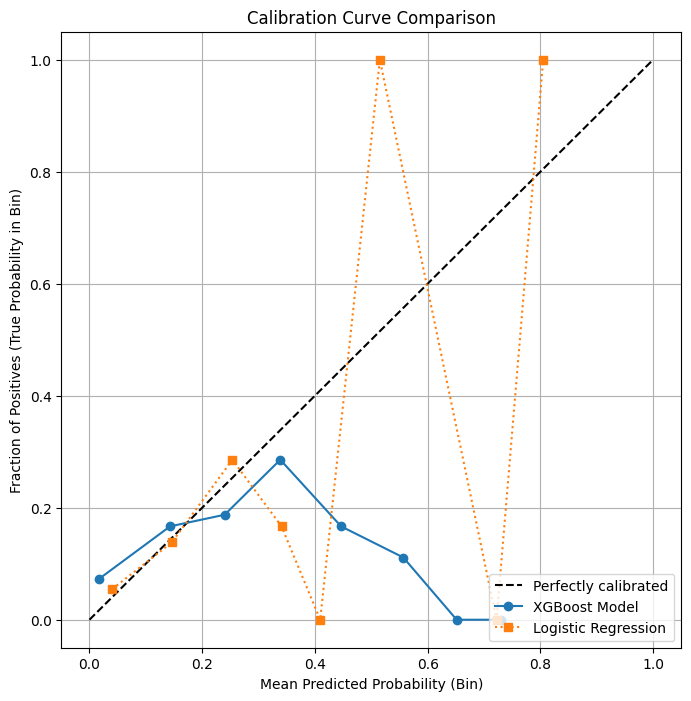

In [16]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# XGBoost
# Obter probabilidades previstas
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
# Calcular dados da curva de calibração
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, y_pred_proba_xgb, n_bins=10, strategy='uniform') # 'uniform' or 'quantile'

# Regressão logística
y_pred_proba_lr = log_reg.predict_proba(X_test)[:, 1]
prob_true_lr, prob_pred_lr = calibration_curve(y_test, y_pred_proba_lr, n_bins=10, strategy='uniform')

# Plot
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')

# Curva de calibração do XGBoost
plt.plot(prob_pred_xgb, prob_true_xgb, marker='o', linestyle='-', label='XGBoost Model')

# Curva de calibração da Regressão Logística
plt.plot(prob_pred_lr, prob_true_lr, marker='s', linestyle=':', label='Logistic Regression')

plt.xlabel('Mean Predicted Probability (Bin)')
plt.ylabel('Fraction of Positives (True Probability in Bin)')
plt.title('Calibration Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Apesar de a Regressão Logística apresentar melhor acurácia e AUC no teste em comparação com o XGBoost, ambos os modelos exibem desafios na classificação da classe minoritária, conforme indicado pelos baixos recall e, em alguns casos, precisão nos relatórios de classificação. A curva de calibração revela que, embora o XGBoost mostre uma calibração razoável em probabilidades mais baixas, ele subestima a probabilidade real em previsões de alta confiança, enquanto a Regressão Logística apresenta uma calibração consistentemente pior. Essa má calibração, que afeta a interpretabilidade das probabilidades previstas, não é diretamente refletida nas métricas de acurácia e AUC, que focam no desempenho geral da classificação e na capacidade de discriminação, respectivamente, destacando a importância da análise da curva de calibração para avaliar a confiabilidade das probabilidades geradas pelos modelos.

## Questão 3
Aplique o seu model de xG treinado na questão anterior para prever a probabilidade de gol de todos os chutes do dataframe "shots". Reporte essas probabilidades no dataframe "shots" em uma coluna "xG".

Em seguida, crie duas listas, exibindo:
- os 10 jogadores com maior xG
- os 10 jogadores com maior diferença de Gols e xG

Discuta os resultados.
- O seu modelo fez um bom trabalho para prever os gols?
- Como você explica a diferença de gols e xG?

In [17]:
# Aplicar o modelo treinado a shots_clean
shots_clean['xG'] = log_reg.predict_proba(shots_clean[features])[:, 1]

# Agrupar por jogador, somar gols e xG
grouped_shots = shots_clean.groupby('player_name').agg({
    'goal': 'sum',
    'xG': 'sum'
}).reset_index()
grouped_shots['goal_xG_diff'] = grouped_shots['goal'] - grouped_shots['xG']
top_xG_players = grouped_shots.sort_values(by='xG', ascending=False).head(10)
top_diff_players = grouped_shots.sort_values(by='goal_xG_diff', ascending=False).head(10)

print("\n10 jogadores com maior xG:")
print(top_xG_players)
print("\n10 jogadores com maior diferença (Gols - xG):")
print(top_diff_players)


10 jogadores com maior xG:
                             player_name  goal        xG  goal_xG_diff
269        Neymar da Silva Santos Junior     2  2.804124     -0.804124
225                          Marcus Berg     0  2.484321     -2.484321
90     Edinson Roberto Cavani G\u00f3mez     3  2.334594      0.665406
229            Mario Mand\u017euki\u0107     3  2.255904      0.744096
310                 Romelu Lukaku Menama     4  2.187761      1.812239
12              Aleksandar Mitrovi\u0107     1  2.046536     -1.046536
142               Ivan Peri\u0161i\u0107     3  1.942054      1.057946
304  Roberto Firmino Barbosa de Oliveira     1  1.828067     -0.828067
132                           Harry Kane     3  1.776256      1.223744
116      Gerard Piqu\u00e9 Bernab\u00e9u     0  1.624991     -1.624991

10 jogadores com maior diferença (Gols - xG):
                                player_name  goal        xG  goal_xG_diff
79                          Denis Cheryshev     4  0.676631      3.323

As listas mostram que o modelo identificou corretamente jogadores ofensivos proeminentes como aqueles com as maiores chances esperadas, refletindo a qualidade e volume de suas oportunidades. Por outro lado, a lista de diferença Gols-xG destaca jogadores que superaram drasticamente suas expectativas, indicando finalização clínica excepcional, gols de baixa probabilidade ou uma sequência de sorte/eficiência acima da média nesse dataset.

O modelo consegue avaliar a qualidade média das chances criadas, identificando corretamente quem teve as melhores oportunidades, mas não previu perfeitamente os resultados individuais de cada chute, como evidenciado pelas grandes diferenças entre Gols e xG. Ele quantifica o perigo da oportunidade, mas a conversão real depende de fatores adicionais como habilidade de finalização individual e sorte, que o modelo não captura completamente.


A diferença entre os gols marcados e o xG é explicada principalmente pela variação na habilidade de finalização dos jogadores, fatores contextuais não modelados (como pressão defensiva, posicionamento do goleiro, técnica específica do chute) e a variância inerente ao futebol, que faz com que alguns jogadores convertam chances difíceis ou percam chances fáceis em um determinado período.

## Questão 4 (opcional)
Carregue os [dados das 5 grandes ligas européias do StatsBomb](https://statsbomb.com/news/the-2015-16-big-5-leagues-free-data-release-la-liga/). Use o [guia do statsbomb para carregar os dados](https://statsbomb.com/articles/soccer/using-statsbomb-free-data-in-python/), se quiser.

Note que as métricas e o formato dos dados são diferentes.

Com os dados da StatsBomb, crie um novo modelo de xG. Você pode usar as mesmas ideias do modelo da questão 1, ou pode fazer um modelo novo.

Compare e discuta seus resultados.